In [222]:
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2
import pei.laborfunctions as lf
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from dask.diagnostics import ProgressBar
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
plt.style.use('/home/aos/kyan/.config/matplotlib/esm2m.mplstyle')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Data

In [87]:
# Population data
ds_pop_esm2m = xr.open_dataset('../data/processed/GFDL/population_regrid_esm2m_2.nc')['population']
ds_pop_esm2m = ds_pop_esm2m.where(np.isfinite(ds_pop_esm2m),0)

In [230]:
# Load area data
land_area_esm2m = xr.open_dataset('../data/processed/GFDL/esm2m.land_area')['land_area']
land_mask = np.isfinite(land_area_esm2m)
# Replace NaN with 0 
land_area_esm2m = land_area_esm2m.where(land_mask,0)

In [88]:
# Temp and WBGT data
tref_esm2m = xr.open_dataarray('../data/processed/GFDL/Map_Data/tref_seasonal.nc')
wbgt_esm2m = xr.open_dataarray('../data/processed/GFDL/Map_Data/wbgt_seasonal.nc')

In [45]:
def summer_avg(ds):
    '''Function to get annual summertime average'''
    # Summer average for Northern hemisphere
    ds_north = ds.where(ds['lat']>=0,drop=True)
    ds_north = ds_north.sel(time=(ds_north['time.month'] == 8))
    
    # Summer average for Southern hemisphere
    ds_south = ds.where(ds['lat']<0,drop=True)
    ds_south = ds_south.sel(time=(ds_south['time.month'] == 2))
    
    # Join Northern and Southern
    ds_summer = xr.concat([ds_south,ds_north],dim='lat')
    
    # Reduce coord from time to year
    ds_summer = ds_summer.groupby('time.year').sum()
    
    return ds_summer

In [89]:
tref_summer_esm2m = summer_avg(tref_esm2m) - 273.15
wbgt_summer_esm2m = summer_avg(wbgt_esm2m)

# Maps

In [214]:
def plot_compare(tref_hist,tref_future,wbgt_hist,wbgt_future):
    # Specify projection
    crs = ccrs.Robinson()

    # Create figure and axes
    fig, axs = plt.subplots(ncols=3,nrows=2,figsize=(16,8.5),subplot_kw={'projection':crs},gridspec_kw={'width_ratios': [0.1,3,3]})
    levels_temp = np.linspace(20,40,9)
    levels_wbt = np.linspace(20,30,9)

    im1 = lf.contour(tref_hist,'\n1980-2000 Summertime Mean\n',axs[0][1],levels=levels_temp,cmap='Reds',label='t_ref',over=None,crop=True)
    lf.contour(tref_future,'\n2080-2100 Summertime Mean\n',axs[0][2],levels=levels_temp,cmap='Reds',label='t_ref',over=None,crop=True)

    im2 = lf.contour(wbgt_hist,None,axs[1][1],levels=levels_wbt,cmap='RdPu',label='Temperature',over=None,crop=True)
    lf.contour(wbgt_future,None,axs[1][2],levels=levels_wbt,cmap='RdPu',label='WBT',over=None,crop=True)

    fig.subplots_adjust(right=0.85)
    cbar_ax1 = fig.add_axes([0.875, 0.525, 0.02, 0.35])
    cbar = fig.colorbar(im1, cax=cbar_ax1, orientation='vertical',format='%.1f');
    cbar.set_label('\t$^\circ$C',fontsize=22,rotation=0)
    cbar.set_ticks(np.linspace(20,40,5))

    cbar_ax2 = fig.add_axes([0.875, 0.125, 0.02, 0.35])
    cbar = fig.colorbar(im2, cax=cbar_ax2, orientation='vertical');
    cbar.set_label('\t$^\circ$C',fontsize=22,rotation=0)
    cbar.set_ticks(np.linspace(20,30,5))
    
    # Annotating text
    axs[0][0].text(0.5,0.5,'$T_{ref}$',fontsize=22,horizontalalignment='right',verticalalignment='center');
    axs[0][0].set_frame_on(False)
    axs[1][0].text(0.5,0.5,'$WBGT$',fontsize=22,horizontalalignment='right',verticalalignment='center');
    axs[1][0].set_frame_on(False)

    fig.subplots_adjust(wspace=.02,hspace=.05)
    fig.suptitle('ESM2M Temperature and Wet-bulb Globe Temperature: Historical Versus Future',fontweight='bold');

In [98]:
tref_hist = tref_summer_esm2m.sel(year=slice(1980,1999)).mean('year')
tref_future = tref_summer_esm2m.sel(year=slice(2080,2099)).mean('year')

wbgt_hist = wbgt_summer_esm2m.sel(year=slice(1980,1999)).mean('year')
wbgt_future = wbgt_summer_esm2m.sel(year=slice(2080,2099)).mean('year')

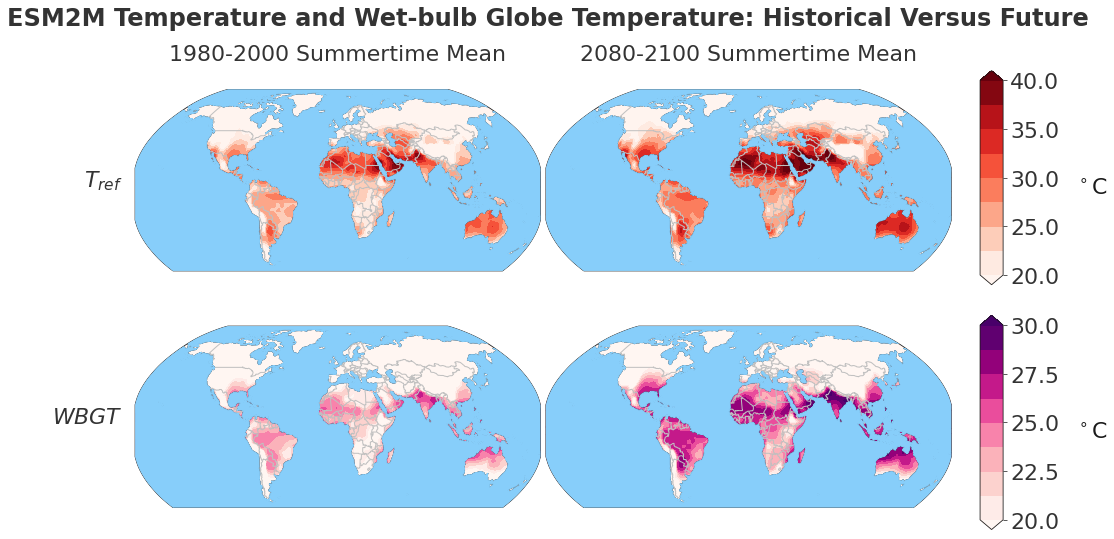

In [215]:
plot_compare(tref_hist,tref_future,wbgt_hist,wbgt_future)
plt.savefig('temp_wbgt_map_esm2m.png',dpi=300)

In [219]:
def plot_diff(tref_hist,tref_future,wbgt_hist,wbgt_future):
    # Specify projection
    crs = ccrs.Robinson()
    levels=np.linspace(1,5,9)
    cmap='YlOrRd'

    # Create figure and axes
    fig, axs = plt.subplots(ncols=2,figsize=(16,5),subplot_kw={'projection':crs})

    im1 = lf.contour(tref_future-tref_hist,'$\Delta T_{ref}$',axs[0],levels=levels,cmap=cmap,label='t_ref',over=None,crop=True)
    lf.contour(wbgt_future-wbgt_hist,'$\Delta WBGT$',axs[1],levels=levels,cmap=cmap,label='t_ref',over=None,crop=True)
    
    # Single colorbar for all plots
    fig.subplots_adjust(bottom=0.2)
    cbar_ax = fig.add_axes([0.3, 0.15, 0.4, 0.075])
    cbar = fig.colorbar(im1, cax=cbar_ax,orientation='horizontal',format='%.1f');
    cbar.set_label('$^\circ$C',fontsize=22)
    cbar.set_ticks(np.linspace(1,5,5))
    
    fig.subplots_adjust(wspace=.02)
    
    fig.suptitle('ESM2M Difference in Temperature and Wet-bulb Globe Temperature',fontweight='bold')

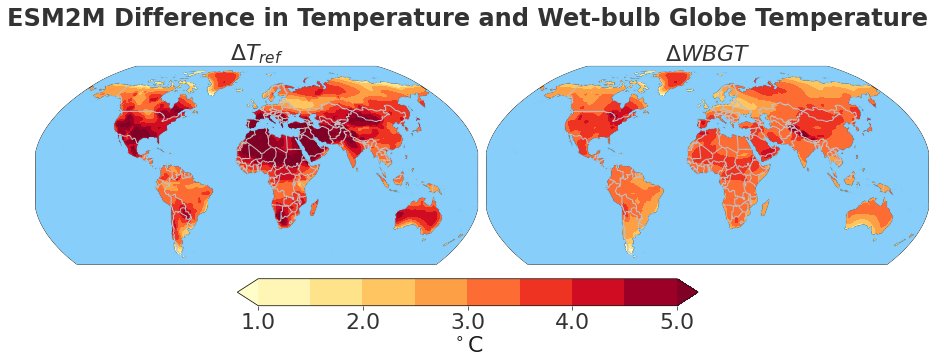

In [220]:
plot_diff(tref_hist,tref_future,wbgt_hist,wbgt_future)
plt.savefig('temp_wbgt_diff_esm2m.png',dpi=300)

# Time Series

In [231]:
global_tref_esm2m = tref_summer_esm2m.weighted(land_area_esm2m).mean(['lat','lon']).isel(year=slice(0,-1))
global_wbgt_esm2m = wbgt_summer_esm2m.weighted(land_area_esm2m).mean(['lat','lon']).isel(year=slice(0,-1))

regional_tref_esm2m = tref_summer_esm2m.sel(lat=slice(-45,45))
regional_tref_esm2m = regional_tref_esm2m.weighted(land_area_esm2m).mean(['lat','lon']).isel(year=slice(0,-1))

regional_wbgt_esm2m = wbgt_summer_esm2m.sel(lat=slice(-45,45))
regional_wbgt_esm2m = regional_wbgt_esm2m.weighted(land_area_esm2m).mean(['lat','lon']).isel(year=slice(0,-1))

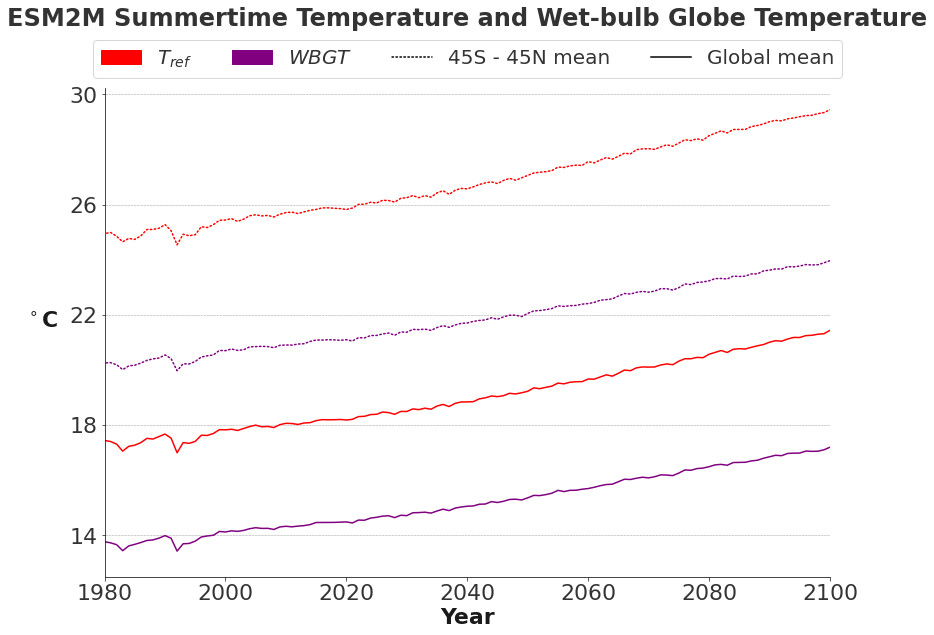

In [245]:
fig,ax=plt.subplots(figsize=(13,9))

global_tref_esm2m.plot(ax=ax,color='red')
regional_tref_esm2m.plot(ax=ax,color='red',linestyle='dotted')

global_wbgt_esm2m.plot(ax=ax,color='purple')
regional_wbgt_esm2m.plot(ax=ax,color='purple',linestyle='dotted')

ax.set_xlim([1980,2100])
ax.set_yticks(np.linspace(14,30,5))
ax.set_xlabel('Year',fontweight='bold')
ax.set_ylabel('$^\circ$C\t',rotation=0,fontweight='bold')

# Legend for different thresholds + models
red_patch = mpatches.Patch(color='red', label='$T_{ref}$')
purple_patch = mpatches.Patch(color='purple', label='$WBGT$')

solid_line = mlines.Line2D([], [], color='black', linestyle='solid', label='Global mean')
dot_line = mlines.Line2D([], [], color='black', linestyle='dotted', label='45S - 45N mean')

ax.legend(handles=[red_patch,purple_patch,dot_line,solid_line],ncol=4,loc='lower center',bbox_to_anchor=(0.5,1));

ax.set_title('ESM2M Summertime Temperature and Wet-bulb Globe Temperature\n\n',fontsize=24,fontweight='bold');
plt.savefig('temp_wbgt_timeseries_esm2m.png',dpi=300)